# Implementation of Rwanda's GDP using GBM model

**Loading our dataset given from the World Bank**

**Sample of the given data in USD**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.ticker as ticker

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

# Given Rwanda's GDP data (1960-2023)
gdp_data = {
    'Year': list(range(1960, 2024)),
    'GDP': [119000024, 122000016, 125000008, 128000000, 129999994, 148799980, 124525702.857143, 159560018, 172200018, 188700037,
            219900006, 222952504.40607, 246457838.336681, 290746157.145921, 308458423.183854, 571863500.248658, 637753853.12552,
            746650613.034794, 905709076.42303, 1109346130.95265, 1254765641.52116, 1407062526.91521, 1407243139.2545, 1479687586.94292,
            1587413083.9206, 1715626330.59472, 1944710683.87148, 2157432667.61598, 2395492686.78165, 2405022593.05165, 2550185679.08109,
            1911600236.67461, 2029026961.55894, 1971525711.83511, 753636370.454545, 1293535193.49248, 1382334879.40812, 1851558197.31088,
            1989343546.17594, 2157108262.84452, 2068836754.37431, 1966600715.49841, 1966003468.49117, 2138237278.73822, 2376496067.01198,
            2933819766.17656, 3319784538.73346, 4070507894.61656, 5179854064.57033, 5674476969.06444, 6124756654.12346, 6884913658.10632,
            7654761573.54991, 7819963715.75353, 8238966063.86692, 8543759677.58157, 8695272300.91019, 9252834336.49492, 9637904655.17446,
            10349300380.33, 10174387374.3478, 11069280649.6459, 13316160895.0447, 14097768472.1883]
}

# Create DataFrame with actual GDP data
df = pd.DataFrame(gdp_data)
df.head(10)

,Year,GDP
0,1960,1.190000e+08
1,1961,1.220000e+08
2,1962,1.250000e+08
3,1963,1.280000e+08
4,1964,1.300000e+08
5,1965,1.488000e+08
6,1966,1.245257e+08
7,1967,1.595600e+08
8,1968,1.722000e+08
9,1969,1.887000e+08


**Logarithmic transformation, calculation of log returns, estimating some parameters**

In [ ]:
# 1. Logarithmic transformation
df['Log_GDP'] = np.log(df['GDP'])

# 2. Calculate log-returns
df['Log_Return'] = df['Log_GDP'].diff()

# Remove the first row with NaN log return
df_returns = df.dropna()

# 3. Parameter estimation
# Mean log-return
mean_log_return = df_returns['Log_Return'].mean()

# Variance of log-returns
var_log_returns = df_returns['Log_Return'].var(ddof=1)

# Standard deviation (volatility)
volatility = np.sqrt(var_log_returns)

# Drift parameter
drift = mean_log_return + (var_log_returns / 2)

# Print parameter estimates
print(f"Estimated Parameters from Historical Data (1960-2023):")
print(f"Mean Log Return (μ): {mean_log_return:.4f}")
print(f"Volatility (σ): {volatility:.4f}")
print(f"Drift Parameter (μ + σ²/2): {drift:.4f}")

Estimated Parameters from Historical Data (1960-2023):
Mean Log Return (μ): 0.0758
Volatility (σ): 0.1839
Drift Parameter (μ + σ²/2): 0.0927


**GBM simulation function**

In [ ]:
def simulate_gbm(S0, drift, volatility, T, dt, num_simulations=1):
    """
    Simulate Geometric Brownian Motion.

    Parameters:
    S0 - initial value
    drift - drift coefficient
    volatility - volatility coefficient
    T - total time
    dt - time step
    num_simulations - number of simulation paths

    Returns:
    Array of simulated values
    """
    num_steps = int(T / dt)
    paths = np.zeros((num_simulations, num_steps + 1))

    # Initial values
    paths[:, 0] = S0

    # Simulate num_simulations paths
    for t in range(1, num_steps + 1):
        # Generate random normal numbers
        z = np.random.normal(0, 1, num_simulations)

        # GBM formula for log-returns
        paths[:, t] = paths[:, t-1] * np.exp((drift - 0.5 * volatility**2) * dt +
                                            volatility * np.sqrt(dt) * z)

    return paths

**Simulating the historical period**

In [ ]:
# Initial GDP (1960)
import numpy as np
np.random.seed(42)

S0 = df['GDP'].iloc[0]
# Total time (years)
T = len(df) - 1
# Time step (1 year)
dt = 1

# Simulate multiple paths for historical period
num_simulations = 1000
historical_simulations = simulate_gbm(S0, drift, volatility, T, dt, num_simulations)

# Calculate median, 5th and 95th percentiles of simulations for each year
simulated_median = np.median(historical_simulations, axis=0)
simulated_lower = np.percentile(historical_simulations, 5, axis=0)
simulated_upper = np.percentile(historical_simulations, 95, axis=0)

# Create DataFrame with actual and simulated data for comparison
comparison_df = pd.DataFrame({
    'Year': df['Year'],
    'Actual_GDP': df['GDP'],
    'Simulated_GDP_Median': simulated_median,
    'Simulated_GDP_Lower': simulated_lower,
    'Simulated_GDP_Upper': simulated_upper
})

# Forecasting for next 10 years
# Initial value is the last actual GDP value
S0_forecast = df['GDP'].iloc[-1]
# Time period for forecast
T_forecast = 10
# Simulate forecast paths
forecast_simulations = simulate_gbm(S0_forecast, drift, volatility, T_forecast, dt, num_simulations)

# Calculate median, 5th and 95th percentiles for forecasts
forecast_median = np.median(forecast_simulations, axis=0)
forecast_lower = np.percentile(forecast_simulations, 5, axis=0)
forecast_upper = np.percentile(forecast_simulations, 95, axis=0)

# Create DataFrame for forecasts - making sure lengths match
forecast_years = list(range(2024, 2024 + len(forecast_median)))
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'Forecast_GDP_Median': forecast_median,
    'Forecast_GDP_Lower': forecast_lower,
    'Forecast_GDP_Upper': forecast_upper
})

**Predictions of the next 10 years**

In [ ]:
#print(forecast_df)
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Shows 8 decimal places

# Print the DataFrame with full precision
print(forecast_df)

# (Optional) Reset to default pandas display settings afterward
pd.reset_option('display.float_format')

    Year  Forecast_GDP_Median  Forecast_GDP_Lower  Forecast_GDP_Upper
0   2024      14097768472.188     14097768472.188     14097768472.188
1   2025      15271113303.333     11187327587.661     20883487193.486
2   2026      16746442635.640     10824716917.606     25566220858.382
3   2027      17815023583.042     10496475341.597     29464808811.841
4   2028      19094445240.768     10676977310.337     35288204154.174
5   2029      20835439288.010     10593315952.578     40967106393.794
6   2030      22648082159.812     11052982919.769     46940177793.266
7   2031      24153104217.048     11354182516.582     52167250634.797
8   2032      26559498341.232     11615036308.264     58074945834.116
9   2033      28123500241.570     11659596879.821     67021789012.647
10  2034      30405347546.672     11856121842.515     77600117099.882


**Calculation of the model performance metrics**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(df['GDP'], simulated_median)
rmse = np.sqrt(mean_squared_error(df['GDP'], simulated_median))
mape = np.mean(np.abs((df['GDP'] - simulated_median) / df['GDP'])) * 100

# Normalize MAE and RMSE by mean GDP
mean_gdp = df['GDP'].mean()
norm_mae = mae / mean_gdp
norm_rmse = rmse / mean_gdp

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): ${mae/1e6:.2f} million")
print(f"Root Mean Squared Error (RMSE): ${rmse/1e6:.2f} million")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Normalized MAE: {norm_mae:.4f} ({norm_mae*100:.2f}%)")
print(f"Normalized RMSE: {norm_rmse:.4f} ({norm_rmse*100:.2f}%)")


Model Performance Metrics:
Mean Absolute Error (MAE): $593.09 million
Root Mean Squared Error (RMSE): $757.83 million
Mean Absolute Percentage Error (MAPE): 28.90%
Normalized MAE: 0.1844 (18.44%)
Normalized RMSE: 0.2356 (23.56%)


In [ ]:
def simulate_gbm_paths(S0, mu, sigma, T, N, num_paths):
    """
    Simulate Geometric Brownian Motion paths

    Parameters:
    -----------
    S0 : float
        Initial value
    mu : float
        Drift parameter
    sigma : float
        Volatility parameter
    T : int
        Time horizon in years
    N : int
        Number of time steps
    num_paths : int
        Number of simulation paths

    Returns:
    --------
    np.array
        Array of simulated paths
    """
    dt = T / N
    paths = np.zeros((N+1, num_paths))
    paths[0] = S0

    # Pre-calculate drift adjustment
    drift_adj = (mu - 0.5 * sigma**2) * dt
    vol_factor = sigma * np.sqrt(dt)

    for t in range(1, N+1):
        # Generate random shocks
        Z = np.random.normal(0, 1, num_paths)
        # Update paths
        paths[t] = paths[t-1] * np.exp(drift_adj + vol_factor * Z)

    return paths
# Simulation parameters
S0 = df['GDP'][0]  # Initial GDP (1960)
T = len(df) - 1     # Time horizon (63 years: 1960-2023)
N = T               # Use annual steps
num_paths = 10000   # Number of simulation paths

# Run GBM simulation
gbm_paths = simulate_gbm_paths(S0, mean_log_return, volatility, T, N, num_paths)

# Create a DataFrame for simulated paths with years as index
years = np.array(df['Year'])
simulated_df = pd.DataFrame(gbm_paths, index=years)

# Calculate summary statistics for simulated paths
summary_stats = pd.DataFrame({
    'Year': years,
    'Actual_GDP': df['GDP'].values,
    'Simulated_Mean': np.mean(gbm_paths, axis=1),
    'Simulated_Median': np.median(gbm_paths, axis=1),
    'Simulated_Lower_95': np.percentile(gbm_paths, 2.5, axis=1),
    'Simulated_Upper_95': np.percentile(gbm_paths, 97.5, axis=1)
})

In [ ]:
# Theil's U Statistic (a measure of forecast accuracy)
def calculate_theils_u(actual, predicted):
    """
    Calculate Theil's U Statistic

    U = √[Σ(Forecast_t - Actual_t)² / Σ(Actual_t)²]

    - U = 0: Perfect forecast
    - U < 1: Better than naive forecast
    - U = 1: Same as naive forecast
    - U > 1: Worse than naive forecast
    """
    actual_array = np.array(actual)
    predicted_array = np.array(predicted)

    # Calculate the numerator (squared error)
    numerator = np.sum((predicted_array - actual_array) ** 2)

    # Calculate the denominator (squared actual values)
    denominator = np.sum(actual_array ** 2)

    # Avoid division by zero
    if denominator == 0:
        return np.nan

    # Calculate Theil's U
    theils_u = np.sqrt(numerator / denominator)

    return theils_u

# Calculate the additional metrics
theils_u_gbm = calculate_theils_u(df['GDP'], summary_stats['Simulated_Median'])

print("\nAdditional Model Performance Metrics:")
print(f"Theil's U Statistic: {theils_u_gbm:.4f}")

# Interpretation of results
print("\nMetrics Interpretation:")
print("Theil's U: Lower is better. Values below 1 indicate the model performs better than a naive forecast.")


Additional Model Performance Metrics:
Theil's U Statistic: 0.6388

Metrics Interpretation:
Theil's U: Lower is better. Values below 1 indicate the model performs better than a naive forecast.


In [ ]:
# Tracking Signal
def calculate_tracking_signal(actual, predicted):
    """
    Calculate Tracking Signal

    Tracking Signal = Sum of Errors / MAD

    Where MAD = Mean Absolute Deviation = (1/n) * Σ|Actual_t - Forecast_t|

    Note: Values between -4 and +4 are generally considered acceptable
    """
    actual_array = np.array(actual)
    predicted_array = np.array(predicted)

    # Calculate errors
    errors = actual_array - predicted_array

    # Calculate MAD (Mean Absolute Deviation)
    mad = np.mean(np.abs(errors))

    # Avoid division by zero
    if mad == 0:
        return np.nan

    # Calculate tracking signal
    tracking_signal = np.sum(errors) / mad

    return tracking_signal

# Directional Accuracy
def calculate_directional_accuracy(actual, predicted):
    """
    Calculate Directional Accuracy (% of times direction of change is correctly predicted)

    DA = Percentage of times that the predicted direction matches the actual direction
    """
    actual_array = np.array(actual)
    predicted_array = np.array(predicted)

    # Calculate actual and predicted directions (1 for up, -1 for down, 0 for no change)
    actual_direction = np.sign(np.diff(actual_array))
    predicted_direction = np.sign(np.diff(predicted_array))

    # Count correct direction predictions
    correct_directions = np.sum(actual_direction == predicted_direction)

    # Total number of direction changes
    total_changes = len(actual_direction)

    # Calculate directional accuracy as a percentage
    directional_accuracy = (correct_directions / total_changes) * 100

    return directional_accuracy

# Information Coefficient (IC)
def calculate_information_coefficient(actual, predicted):
    """
    Calculate Information Coefficient (correlation between actual and predicted values)

    IC = Correlation between actual and predicted values

    Range: -1 to 1, where 1 is perfect correlation
    """
    # Calculate correlation coefficient
    if np.std(actual) == 0 or np.std(predicted) == 0:
        return np.nan

    ic = np.corrcoef(actual, predicted)[0, 1]

    return ic

# Mean Squared Logarithmic Error (MSLE)
def calculate_msle(actual, predicted):
    """
    Calculate Mean Squared Logarithmic Error

    MSLE = (1/n) * Σ(log(1 + Actual_t) - log(1 + Forecast_t))²

    Note: Less sensitive to outliers than MSE
    """
    actual_array = np.array(actual)
    predicted_array = np.array(predicted)

    # Ensure all values are non-negative (required for log)
    if np.any(actual_array < 0) or np.any(predicted_array < 0):
        return np.nan

    # Calculate MSLE
    msle = np.mean((np.log1p(actual_array) - np.log1p(predicted_array)) ** 2)

    return msle

# Calculate all metrics
tracking_signal_gbm = calculate_tracking_signal(df['GDP'], summary_stats['Simulated_Median'])
directional_accuracy_gbm = calculate_directional_accuracy(df['GDP'], summary_stats['Simulated_Median'])
information_coefficient_gbm = calculate_information_coefficient(df['GDP'], summary_stats['Simulated_Median'])
msle_gbm = calculate_msle(df['GDP'], summary_stats['Simulated_Median'])

In [ ]:
# Print results
print("\nComprehensive Model Performance Metrics:")
print(f"Tracking Signal: {tracking_signal_gbm:.2f}")
print(f"Directional Accuracy: {directional_accuracy_gbm:.2f}%")
print(f"Information Coefficient (IC): {information_coefficient_gbm:.4f}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle_gbm:.6f}")

# Interpretation of results
print("\nMetrics Interpretation:")
print("Tracking Signal: Values between -4 and +4 are generally considered acceptable.")
print("   - Positive values suggest systematic underprediction")
print("   - Negative values suggest systematic overprediction")
print(" Directional Accuracy: Higher is better. Measures % of times the model correctly predicts direction of change.")
print("Information Coefficient (IC): Higher is better. Measures correlation between actual and predicted values.")
print(" MSLE: Lower is better. Less sensitive to outliers than MSE, especially for large values.")


Comprehensive Model Performance Metrics:
Tracking Signal: 63.70
Directional Accuracy: 87.30%
Information Coefficient (IC): 0.9799
Mean Squared Logarithmic Error (MSLE): 0.695208

Metrics Interpretation:
Tracking Signal: Values between -4 and +4 are generally considered acceptable.
   - Positive values suggest systematic underprediction
   - Negative values suggest systematic overprediction
 Directional Accuracy: Higher is better. Measures % of times the model correctly predicts direction of change.
Information Coefficient (IC): Higher is better. Measures correlation between actual and predicted values.
 MSLE: Lower is better. Less sensitive to outliers than MSE, especially for large values.


**Table presenting actual and simulated data.**

In [ ]:
import pandas as pd

# Disable scientific notation for display
pd.options.display.float_format = '{:,.3f}'.format

# Show all rows
pd.set_option('display.max_rows', None)

# Create the comparison table with raw values
full_comparison = comparison_df[['Year', 'Actual_GDP', 'Simulated_GDP_Median']].copy()
full_comparison.columns = ['Year', 'Actual GDP', 'Simulated GDP']

# Display full table with all digits (no exponential notation)
print("\nFull Comparison Table (Raw GDP values):")
print(full_comparison)



Full Comparison Table (Raw GDP values):
    Year         Actual GDP      Simulated GDP
0   1960    119,000,024.000    119,000,024.000
1   1961    122,000,016.000    128,967,896.998
2   1962    125,000,008.000    139,557,629.936
3   1963    128,000,000.000    150,329,736.534
4   1964    129,999,994.000    161,574,530.731
5   1965    148,799,980.000    174,068,758.292
6   1966    124,525,702.857    186,258,916.338
7   1967    159,560,018.000    201,790,837.804
8   1968    172,200,018.000    216,992,526.501
9   1969    188,700,037.000    233,215,573.575
10  1970    219,900,006.000    254,198,777.931
11  1971    222,952,504.406    273,246,727.321
12  1972    246,457,838.337    293,738,104.017
13  1973    290,746,157.146    326,266,017.440
14  1974    308,458,423.184    352,528,356.605
15  1975    571,863,500.249    377,017,000.555
16  1976    637,753,853.126    412,870,847.793
17  1977    746,650,613.035    447,317,997.411
18  1978    905,709,076.423    481,755,070.541
19  1979  1,109,346

**Visualizations of historical vs simulation data**

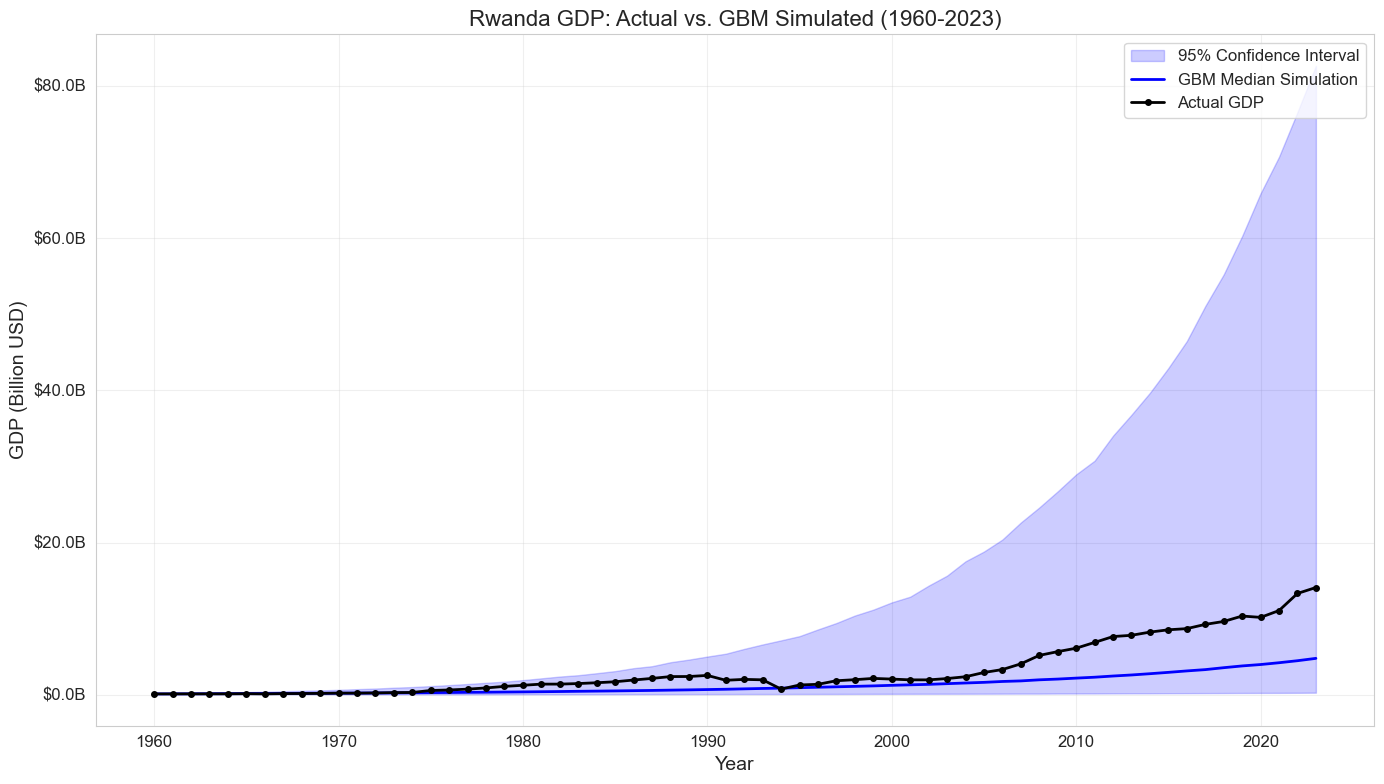

In [ ]:
# Plot actual vs. simulated GDP (with confidence intervals)
plt.figure(figsize=(14, 8))

# Plot 95% confidence interval
plt.fill_between(years,
                summary_stats['Simulated_Lower_95'] / 1e9,
                summary_stats['Simulated_Upper_95'] / 1e9,
                color='blue', alpha=0.2, label='95% Confidence Interval')

# Plot simulated median
plt.plot(years, summary_stats['Simulated_Median'] / 1e9, 'b-', linewidth=2,
         label='GBM Median Simulation')

# Plot actual GDP
plt.plot(years, df['GDP'] / 1e9, 'k-', linewidth=2, marker='o', markersize=4,
         label='Actual GDP')

plt.title('Rwanda GDP: Actual vs. GBM Simulated (1960-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('GDP (Billion USD)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Format y-axis to show billions with 1 decimal place
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:.1f}B'))

plt.tight_layout()
plt.savefig('rwanda_gdp_actual_vs_simulated.png', dpi=300)
plt.show()

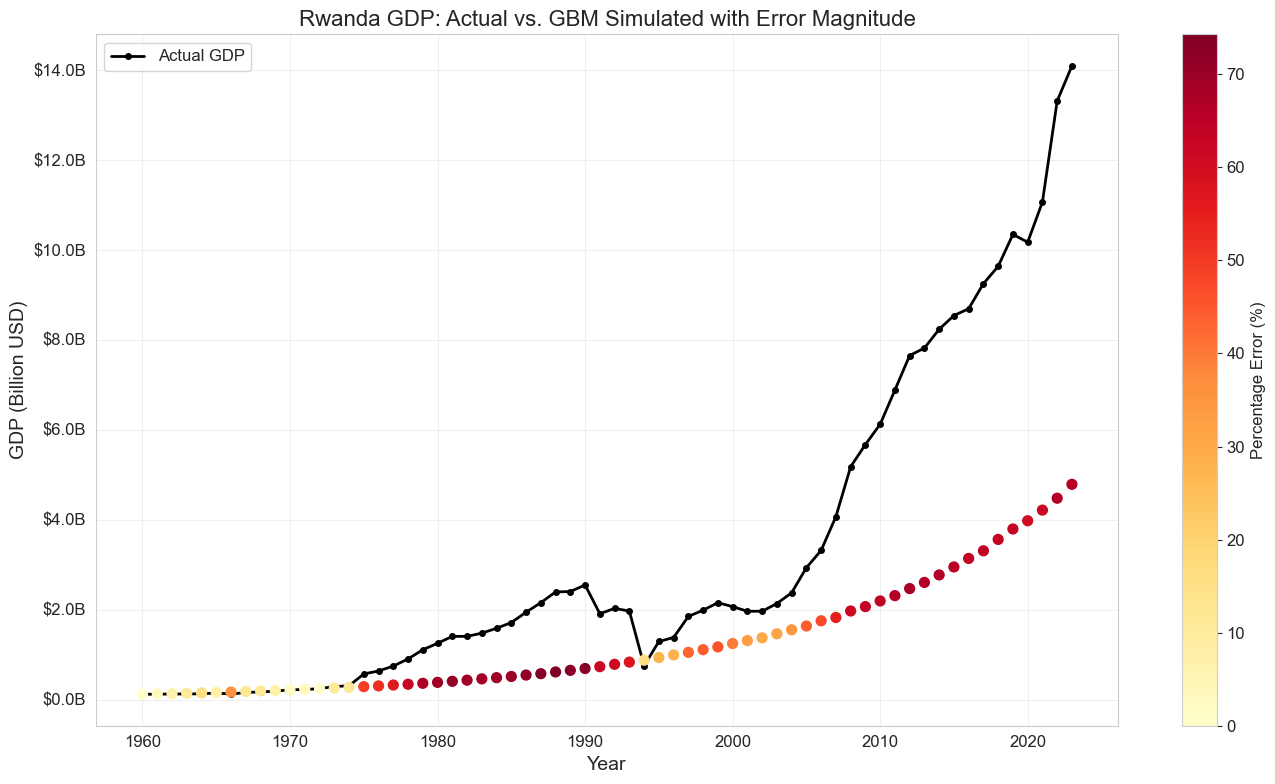

In [ ]:
# Time-series plot with error bands shaded by MAPE
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate percentage errors for each year
pct_errors = np.abs((df['GDP'] - summary_stats['Simulated_Median']) / df['GDP']) * 100
error_colors = plt.cm.YlOrRd(pct_errors / pct_errors.max())

# Plot actual GDP
ax.plot(years, df['GDP'] / 1e9, 'k-', linewidth=2, marker='o', markersize=4,
         label='Actual GDP')

# Plot simulated median with color-coded points based on percentage error
scatter = ax.scatter(years, summary_stats['Simulated_Median'] / 1e9,
                     c=pct_errors, cmap='YlOrRd',
                     s=50, zorder=3)

# Add a colorbar for percentage errors
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Percentage Error (%)', fontsize=12)

ax.set_title('Rwanda GDP: Actual vs. GBM Simulated with Error Magnitude', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('GDP (Billion USD)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

# Format y-axis
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:.1f}B'))

plt.tight_layout()
plt.savefig('rwanda_gdp_with_error_magnitude.png', dpi=300)
plt.show()

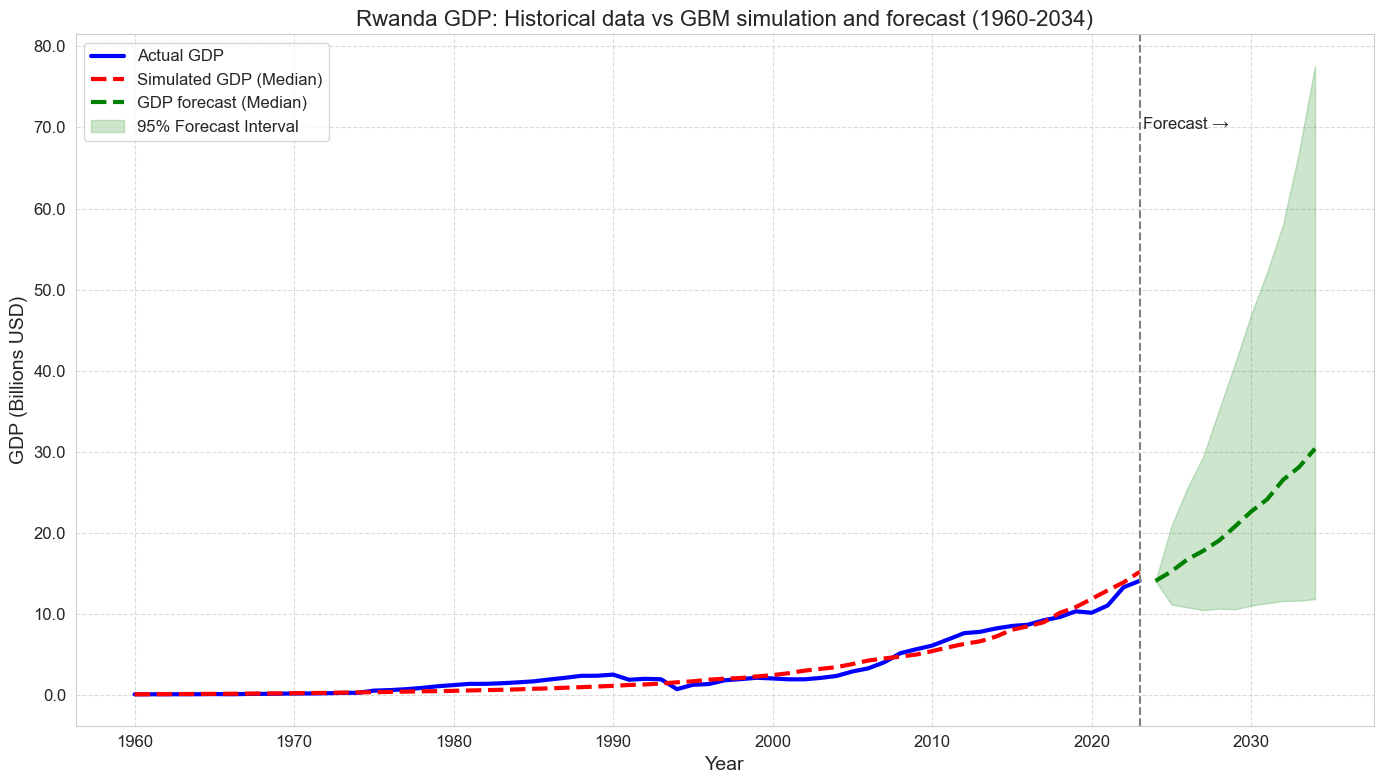

In [ ]:
plt.figure(figsize=(14, 8))

# Plot actual GDP
plt.plot(df['Year'], df['GDP'] / 1e9, 'b-', linewidth=3, label='Actual GDP')

# Plot simulated GDP (median)
plt.plot(df['Year'], simulated_median / 1e9, 'r--', linewidth=3, label='Simulated GDP (Median)')

# Plot confidence interval
# plt.fill_between(df['Year'],
#                 simulated_lower / 1e9,
#                 simulated_upper / 1e9,
#                 alpha=0.2, color='r',
#                 label='95% Confidence Interval')

# Add forecast
plt.plot(forecast_df['Year'], forecast_median / 1e9, 'g--', linewidth=3, label='GDP forecast (Median)')
plt.fill_between(forecast_df['Year'],
                forecast_lower / 1e9,
                forecast_upper / 1e9,
                alpha=0.2, color='g',
                label='95% Forecast Interval')

# Add vertical line to separate historical and forecast periods
plt.axvline(x=2023, color='gray', linestyle='--')
plt.text(2023.2, max(forecast_upper) / 1e9 * 0.9, 'Forecast →', fontsize=12)

# Format y-axis as billions
formatter = ticker.FuncFormatter(lambda x, p: f'{x:.1f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Rwanda GDP: Historical data vs GBM simulation and forecast (1960-2034)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('GDP (Billions USD)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('rwanda_gdp_simulation.png', dpi=300, bbox_inches='tight')
plt.show()